# Evaluation of 10K read depth feature count variablility

## Overview:

Due to an unexpected increase in feature counts for 10K read depth relative to other depths (See Jie_2017_subsampling_expt.ipynb), we want to see if this result is a fluke depended on seed (in which case there will be variability in feature counts) or if this is consistent behavior that just happens around 10K read depth, in which case we would hypothesize that increase in features would be due to increased spurious detection of features.

## Relies on:

* workflow/cmd.sh
* workflow/Snakefile.subsample_kraken2_wf
* workflow/kraken2_wf_config.yaml
* workflow/Snakefile.subsample_wf


In [1]:
import pandas as pd
import numpy as np
import os
import re
from scipy.spatial.distance import jaccard
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib import pyplot as plt

# Data Munging

In [23]:
root_dir = '/project'
top_data_dir = os.path.join(root_dir, 'workflow/PE_subsampling_experiments/insilico_subsampling_seed_experiment')
os.listdir(top_data_dir)

['kraken2_PE_10K_seed87',
 'kraken2_PE_10K_seed47',
 'kraken2_PE_10K_seed207',
 'kraken2_PE_10K_seed42',
 'kraken2_PE_10K_seed29',
 'kraken2_PE_10K_seed93']

In [24]:
data_subdirs = np.array(os.listdir(top_data_dir))
kraken2_subdirs = np.sort(data_subdirs[np.array([len(re.findall('kraken2_PE_10K_seed[0-9]+$', x)) > 0 for x in data_subdirs])])
kraken2_subdirs

array(['kraken2_PE_10K_seed207', 'kraken2_PE_10K_seed29',
       'kraken2_PE_10K_seed42', 'kraken2_PE_10K_seed47',
       'kraken2_PE_10K_seed87', 'kraken2_PE_10K_seed93'], dtype='<U22')

In [25]:
pipeline_metadata = pd.DataFrame({'pipeline_run': kraken2_subdirs, 'depth': np.repeat(10000, len(kraken2_subdirs)),
                                 'seed': np.array([re.findall('[0-9]+$', x)[0] for x in kraken2_subdirs])})
pipeline_metadata = pipeline_metadata.sort_values('seed')
pipeline_metadata

,pipeline_run,depth,seed
0,kraken2_PE_10K_seed207,10000,207
1,kraken2_PE_10K_seed29,10000,29
2,kraken2_PE_10K_seed42,10000,42
3,kraken2_PE_10K_seed47,10000,47
4,kraken2_PE_10K_seed87,10000,87
5,kraken2_PE_10K_seed93,10000,93


In [26]:
def get_matrix(df):
    """
    Get a numeric matrix from data frame
    """
    matrix_cols = np.setdiff1d(df.columns.to_numpy(), ['filename', 'pipeline_run', 'run_acc', 'total_feats', 'depth'])
    mat = df.loc[:, matrix_cols].to_numpy().astype('float32')
    return mat

def get_accs(df):
    """
    Get Run Accessions from DataFrame
    """
    fastq_file_names = df['filename'].to_numpy().astype('str')
    # get run accessions. This will be important for running correlation + overlap comparisons
    run_acc = []
    for x in fastq_file_names:
        m = re.match('^[A-Z]{3}[0-9]+', x)
        if m:
            run_acc.append(m.group(0))
        else:
            raise ValueError('Unexpected run accession {}'.format(x))
            
    df['run_acc'] = np.array(run_acc)
    return df

def get_total_feats(df):
    """
    Get total number of nonzero, non-NA features
    """
    mat = get_matrix(df)
    total_feats = np.array([np.sum(mat[i, :].flatten() > 0) for i in range(mat.shape[0])])
    df['total_feats'] = total_feats
    return df

def load_file(freq_file):
    file_data = pd.read_csv(freq_file)
    file_data = get_accs(file_data)
    file_data = get_total_feats(file_data)
    
    return file_data

In [27]:
# load and merge data from all kraken2 pipeline runs
m = 0
for run in pipeline_metadata['pipeline_run']:
    fpath = os.path.join(top_data_dir, run, 'matrix/freq_mat.csv')
    loaded_df = load_file(fpath)
    # add depth to metadata
    loaded_df['depth'] = np.repeat(pipeline_metadata['depth'][pipeline_metadata['pipeline_run'] == run].to_numpy(), loaded_df.shape[0])
    # add seed to metadata
    loaded_df['seed'] = np.repeat(pipeline_metadata['seed'][pipeline_metadata['pipeline_run'] == run].to_numpy(), loaded_df.shape[0])
    # forces non-duplicate identifier. directories cannot be duplicated, nor can filenames within a directory
    loaded_df['seed_file'] = np.array([str(loaded_df['seed'][i]) + '_' + loaded_df['filename'][i] for i in range(loaded_df.shape[0])])
    melted_df = pd.melt(loaded_df, id_vars='seed_file')
    if m == 0:
        combined_melted_df = melted_df
        m += 1
    else:
        combined_melted_df = combined_melted_df.append(melted_df)
        
melted_df

,seed_file,variable,value
0,93_ERR2017411_seqt.subsampled_1_kneaddata_pair...,filename,ERR2017411_seqt.subsampled_1_kneaddata_paired_...
1,93_ERR2017412_seqt.subsampled_1_kneaddata_pair...,filename,ERR2017412_seqt.subsampled_1_kneaddata_paired_...
2,93_ERR2017413_seqt.subsampled_1_kneaddata_pair...,filename,ERR2017413_seqt.subsampled_1_kneaddata_paired_...
3,93_ERR2017414_seqt.subsampled_1_kneaddata_pair...,filename,ERR2017414_seqt.subsampled_1_kneaddata_paired_...
4,93_ERR2017415_seqt.subsampled_1_kneaddata_pair...,filename,ERR2017415_seqt.subsampled_1_kneaddata_paired_...
...,...,...,...
2105851,93_ERR2017809_seqt.subsampled_1_kneaddata_pair...,seed,93
2105852,93_ERR2017810_seqt.subsampled_1_kneaddata_pair...,seed,93
2105853,93_ERR2017813_seqt.subsampled_1_kneaddata_pair...,seed,93
2105854,93_ERR2017814_seqt.subsampled_1_kneaddata_pair...,seed,93


In [28]:
combined_df = pd.pivot(combined_melted_df, index='seed_file', columns='variable', values='value')
combined_df

variable,Homo sapiens,Blochmannia endosymbiont of Camponotus (Colobopsis) obliquus,Blochmannia endosymbiont of Camponotus nipponensis,Blochmannia endosymbiont of Colobopsis nipponica,Blochmannia endosymbiont of Polyrhachis (Hedomyrma) turneri,Candidatus Aquiluna sp. 15G-AUS-rot,Candidatus Aquiluna sp. UB-MaderosW2red,Chryseobacterium sp.,Chryseobacterium sp. 3008163,Chryseobacterium sp. 6424,...,Sulfolobales Mexican fusellovirus 1,Sulfolobus monocaudavirus SMV4,Human feces pecovirus,Pacmanvirus A23,uncultured Mediterranean phage,depth,filename,run_acc,seed,total_feats
seed_file,,,,,,,,,,,,,,,,,,,,,
207_ERR2017411_seqt.subsampled_1_kneaddata_paired_freq_output.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000,ERR2017411_seqt.subsampled_1_kneaddata_paired_...,ERR2017411,207,194
207_ERR2017412_seqt.subsampled_1_kneaddata_paired_freq_output.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000,ERR2017412_seqt.subsampled_1_kneaddata_paired_...,ERR2017412,207,178
207_ERR2017413_seqt.subsampled_1_kneaddata_paired_freq_output.txt,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000,ERR2017413_seqt.subsampled_1_kneaddata_paired_...,ERR2017413,207,152
207_ERR2017414_seqt.subsampled_1_kneaddata_paired_freq_output.txt,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000,ERR2017414_seqt.subsampled_1_kneaddata_paired_...,ERR2017414,207,135
207_ERR2017415_seqt.subsampled_1_kneaddata_paired_freq_output.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000,ERR2017415_seqt.subsampled_1_kneaddata_paired_...,ERR2017415,207,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93_ERR2017809_seqt.subsampled_1_kneaddata_paired_freq_output.txt,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000,ERR2017809_seqt.subsampled_1_kneaddata_paired_...,ERR2017809,93,324
93_ERR2017810_seqt.subsampled_1_kneaddata_paired_freq_output.txt,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000,ERR2017810_seqt.subsampled_1_kneaddata_paired_...,ERR2017810,93,166
93_ERR2017813_seqt.subsampled_1_kneaddata_paired_freq_output.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000,ERR2017813_seqt.subsampled_1_kneaddata_paired_...,ERR2017813,93,225


In [44]:
# combined_df.to_csv("PE_insilico_sampling_seed_combined_df.csv")

# I. Total Nonzero Features Per Sample

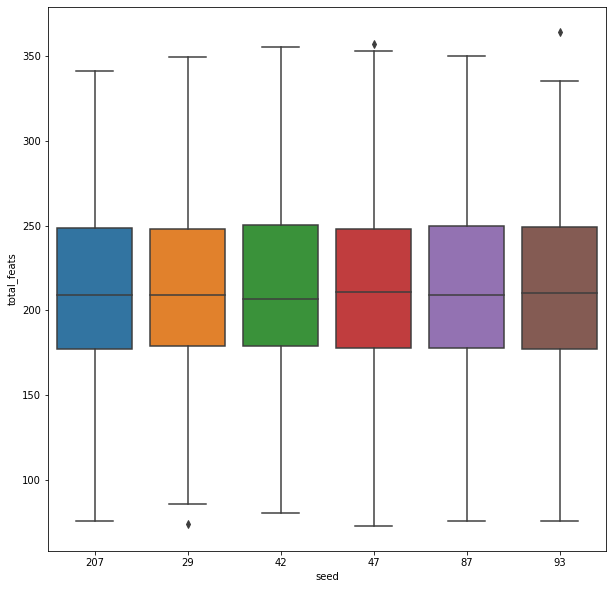

In [29]:
f = plt.figure(figsize=(10,10))
ax = sns.boxplot(data=combined_df, x='seed', y='total_feats')
f.show()

# Overlap + Correlation of Features
Compare all other seeds to 1st seed

In [31]:
seeds_use = combined_df.sort_values('seed')['seed'].unique()
unique_samples = combined_df['run_acc'].unique()
seed0_idx = (combined_df['seed'] == combined_df['seed'][0]).to_numpy()
data_mat = get_matrix(combined_df)
data_mat.shape

(2304, 6556)

In [37]:
stats_dict = {'seed': [], 'run_acc': [], 'jaccard': [], 'cor': [], 'feats_w_seed': [],
              'feats_seed0': [], 'union_feats': [], 'common_feats': []}

for i in range(1, len(seeds_use)):
    seed_i = seeds_use[i]
    seed_i_idx = (combined_df['seed'] == seed_i).to_numpy()
    for s in unique_samples:
        s_idx = (combined_df['run_acc'] == s).to_numpy()
        s_i_idx = np.logical_and(seed_i_idx, s_idx)
        if not np.sum(s_i_idx) == 1:
            assert False
        s_i_vals = data_mat[s_i_idx, :].flatten()
        # set nan values to 0
        s_i_vals[np.logical_not(s_i_vals > 0)] = 0.
        
        s_seed0_idx = np.logical_and(seed0_idx, s_idx)
        if not np.sum(s_seed0_idx) == 1:
            assert False
        s_seed0_vals = data_mat[s_seed0_idx, :].flatten()
        s_seed0_vals[np.logical_not(s_seed0_vals > 0)] = 0.
        # calculate overlap with feats at given depth with feats at 10M reads
        s_i_feats = s_i_vals > 0
        s_seed0_feats = s_seed0_vals > 0
        s_i_overlap = jaccard(s_i_feats, s_seed0_feats)
        # calculate correlation across union of nonzero features
        union_feats = np.logical_or(s_i_feats, s_seed0_feats)
        common_feats = np.logical_and(s_i_feats, s_seed0_feats)
        s_i_cor, _ = pearsonr(s_i_vals[common_feats], s_seed0_vals[common_feats])
        # store values
        stats_dict['seed'].append(seed_i)
        stats_dict['run_acc'].append(s)
        stats_dict['jaccard'].append(s_i_overlap)
        stats_dict['cor'].append(s_i_cor)
        stats_dict['feats_w_seed'].append(np.sum(s_i_feats))
        stats_dict['feats_seed0'].append(np.sum(s_seed0_feats))
        stats_dict['union_feats'].append(np.sum(union_feats))
        stats_dict['common_feats'].append(np.sum(common_feats))
        
stats_df = pd.DataFrame(stats_dict)        

In [38]:
stats_df

,seed,run_acc,jaccard,cor,feats_w_seed,feats_seed0,union_feats,common_feats
0,29,ERR2017411,0.642586,0.952231,162,195,263,94
1,29,ERR2017412,0.596000,0.996519,172,179,250,101
2,29,ERR2017413,0.593301,0.914258,141,153,209,85
3,29,ERR2017414,0.559783,0.859100,129,136,184,81
4,29,ERR2017415,0.637168,0.951853,162,146,226,82
...,...,...,...,...,...,...,...,...
1915,93,ERR2017809,0.692000,0.999435,325,329,500,154
1916,93,ERR2017810,0.530435,0.993819,167,171,230,108
1917,93,ERR2017813,0.652174,0.998528,226,208,322,112
1918,93,ERR2017814,0.611111,0.996540,201,199,288,112


In [45]:
# stats_df.to_csv("PE_insilico_sampling_seed_stats_df.csv")

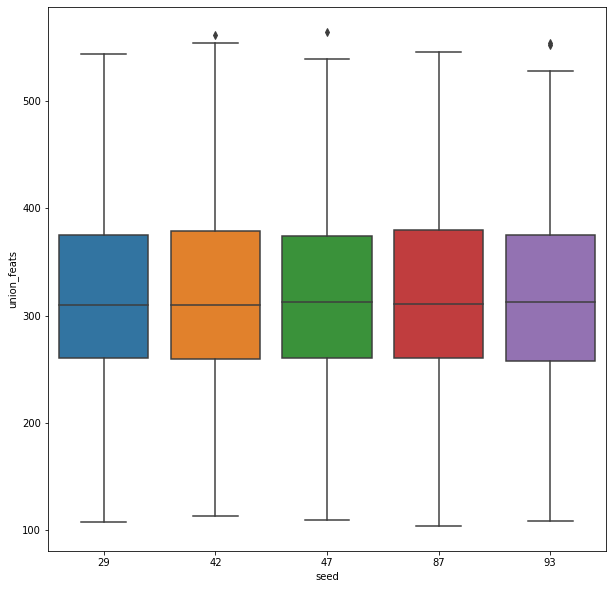

In [39]:
# size of union of nonzero features between first seed and other seeds
f = plt.figure(figsize=(10,10))
ax = sns.boxplot(data=stats_df, x='seed', y='union_feats')
f.show()

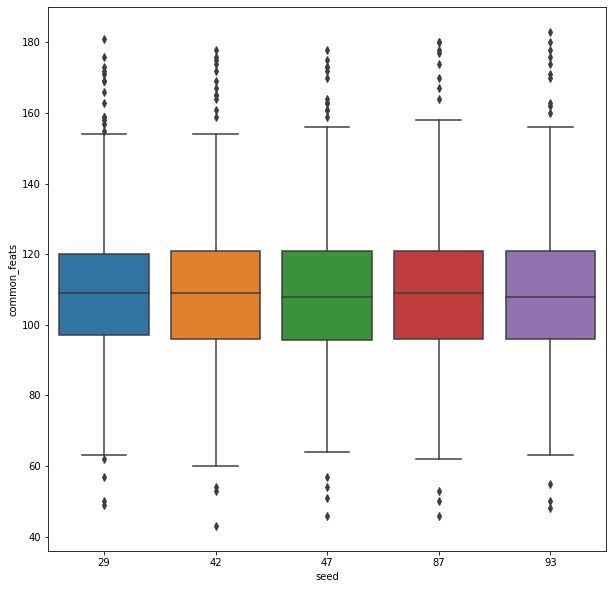

In [40]:
# size of intersection of features between first seed and other seeds
f = plt.figure(figsize=(10,10))
ax = sns.boxplot(data=stats_df, x='seed', y='common_feats')
f.show()

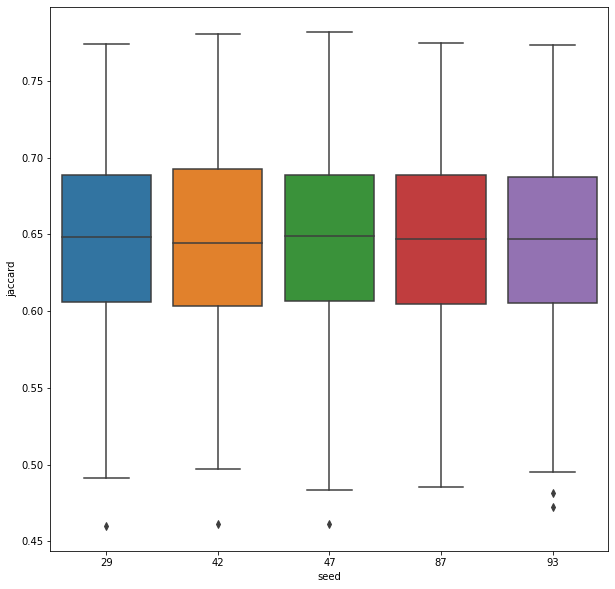

In [42]:
# jaccard distance of nonzero feature sets for first seed and other seeds
# 1.0 = no overlap, 0.0 = perfect overlap
f = plt.figure(figsize=(10,10))
ax = sns.boxplot(data=stats_df, x='seed', y='jaccard')
f.show()

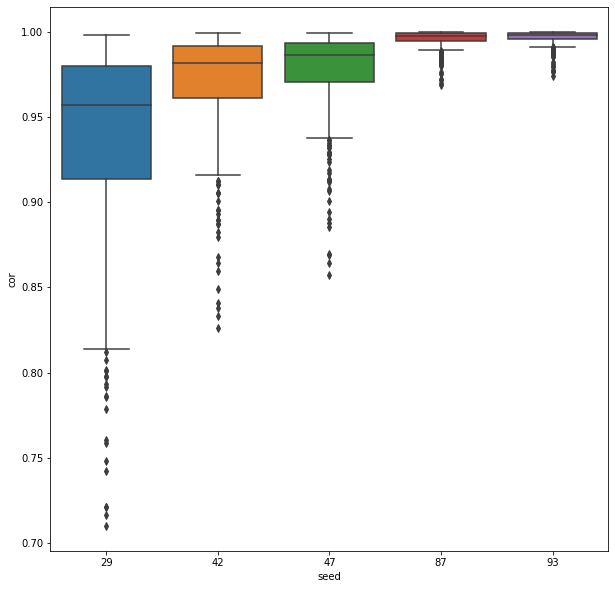

In [43]:
# correlation of common feature set for first seed and other seeds
# at each depth, pearson's correlation is calculated between first seed and other seed's intersection of features
f = plt.figure(figsize=(10,10))
ax = sns.boxplot(data=stats_df, x='seed', y='cor')
f.show()